In [1]:
import sys
sys.path.append('..')
from Comms_System import Comms_System, SNR_plot, network_sender_receiver
from filters import butter_lowpass, ideal_lowpass, ideal_lowpass_torch
import numpy as np
import matplotlib.pyplot as plt
import torch
from NetworkPytorch import joint_train_loop
from DE_Pytorch import DE
from scipy import signal
import scipy
import torchaudio
from scipy.stats import norm
from commpy import rcosfilter
import pandas as pd 

In [2]:
def get_data():

    upsampled = CS.upsample()
    X_tx = torch.Tensor(upsampled).view(1, 1, -1)
    classes = np.array(symbol_set)
    y = symbol_seq
    class_idx = {v: i for i, v in enumerate(classes)}
    y_idx = np.array([class_idx[v] for v in y])
    y = torch.Tensor(y_idx)
    
    return X_tx, y

In [3]:
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 100000
symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)

# Create 1D Convolutional Neural Networks for transmitter and receiver and define optimizer and loss
# Remember to double check padding and general design of NN_tx and NN_rx

Xtrain, ytrain = get_data()
Xtest, ytest = get_data()

NN_tx = torch.nn.Sequential(torch.nn.Conv1d(1, 1, 64, padding=len(CS.h)-1)) # padding=len(CS.h) - 1
NN_rx = torch.nn.Sequential(torch.nn.Conv1d(1, 1, 64), torch.nn.Conv1d(1, 4, 8, stride=8))
criterion = torch.nn.CrossEntropyLoss()
params = list(NN_tx.parameters()) + list(NN_rx.parameters())
optimizer = torch.optim.Adam(params, lr=1e-2)

In [ ]:
# Joint train sender and receiver NN using Backpropagation

epoch_losses = joint_train_loop(NN_tx, NN_rx, Xtrain, ytrain, optimizer, criterion, sample_rate=CS.m, 
                                epochs=500, cutoff_freq=0.57, v=True, use_cuda=False, SNRdb=6.5, plot_iteration=50,
                               lowpass='butter')

plt.figure(figsize=(13, 8))
plt.plot(epoch_losses.to('cpu'))
plt.show()

In [ ]:
NN_tx.to('cpu')
NN_rx.to('cpu')

In [ ]:
# Evaluate
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 10000
symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
NN_tx.to('cpu')
NN_rx.to('cpu')
accs = np.zeros(10)
accs_euclid = np.zeros(10)

for i in range(10):

    SNR = 6.5
    joint_decisions = CS.transmission(SNRdb=SNR, mode='joint', joint_cutoff=0.675, model=[NN_tx, NN_rx], 
                                      lowpass='ideal')
    euclid_decisions = CS.transmission(SNRdb=SNR, mode='euclidean')
    acc = 1 - CS.evaluate(joint_decisions)[1]
    acc_euclid = 1 - CS.evaluate(euclid_decisions)[1]

    #print('Accuracy:', acc)
    #print('Accuracy:', 1 - CS.evaluate(euclid_decisions)[1])
    accs[i] = acc
    accs_euclid[i] = acc_euclid
    
print(np.mean(accs))
print(np.mean(accs_euclid))

## The Models

DE


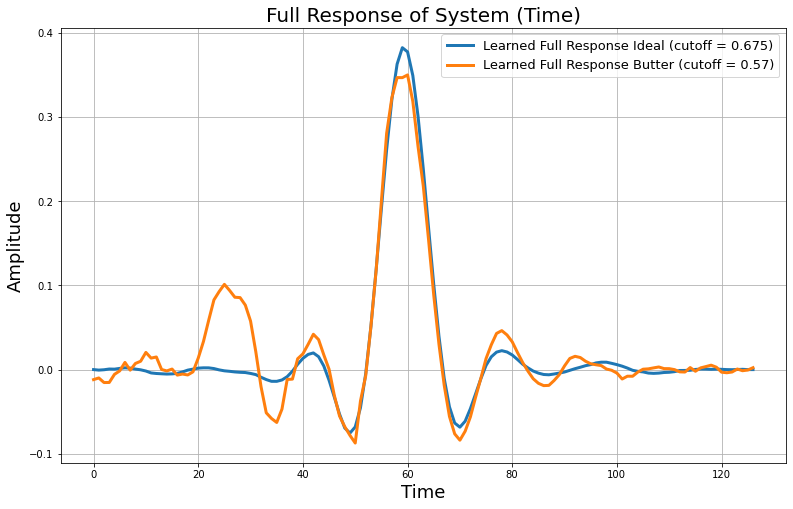

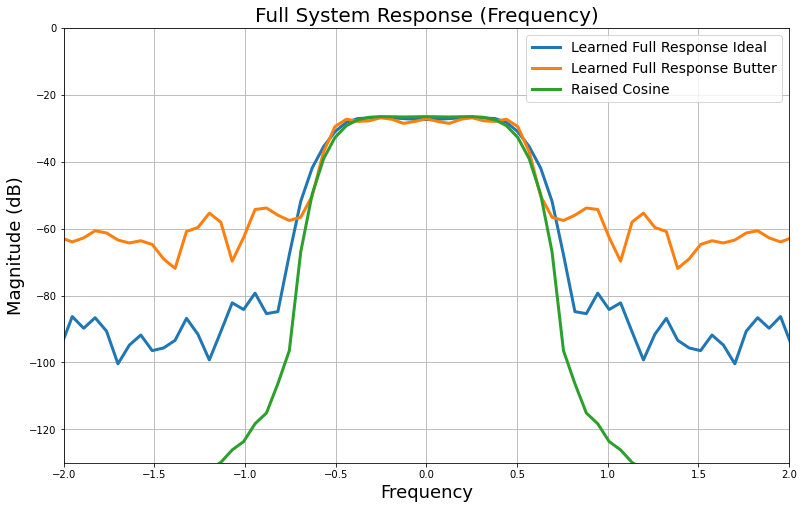

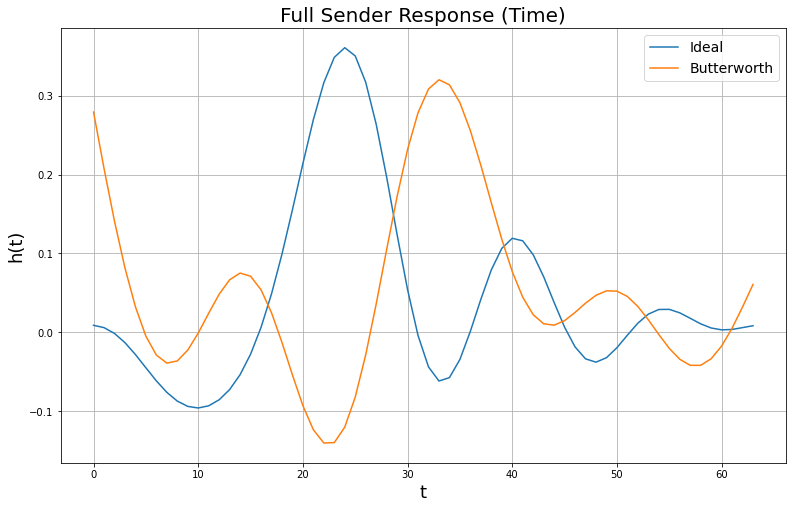

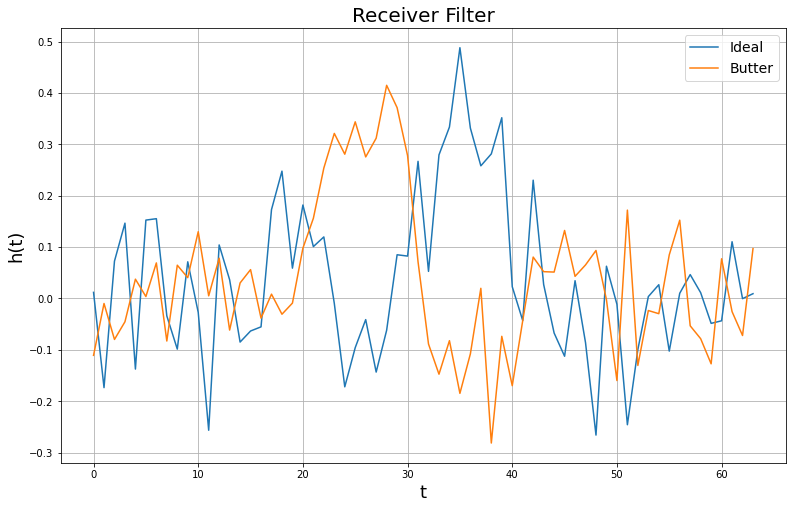

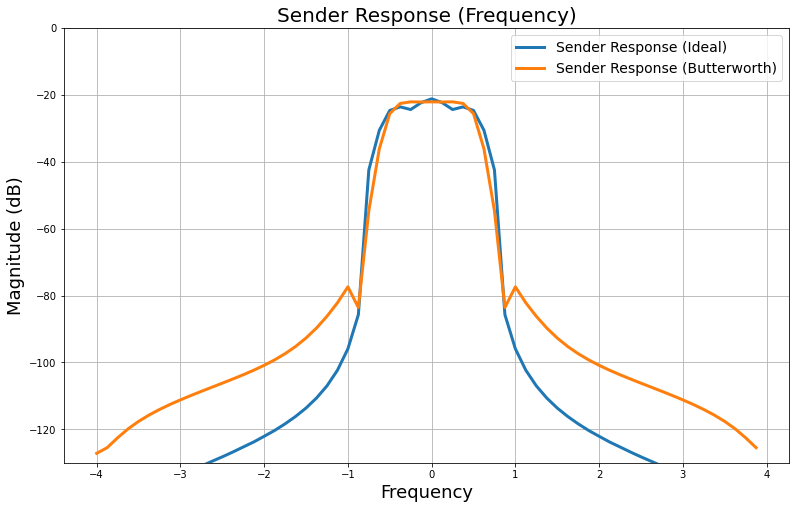

In [21]:
path = '../Joint_Models/'
model_type = 'DE'

if model_type == 'BP':
    print('BP')

    NN_tx_butter = torch.load(path + 'BP_SenderButter06_Final')
    NN_rx_butter = torch.load(path + 'BP_ReceiverButter06_Final')

    NN_tx_ideal = torch.load(path + 'BP_SenderIdeal0.675')
    NN_rx_ideal = torch.load(path + 'BP_ReceiverIdeal0.675')

elif model_type == 'DE':
    print('DE')
    # All DE Ideal models are with cutoff 0.675
    
    NN_tx_butter = torch.load(path + 'DE_SenderButter0.57')
    NN_rx_butter = torch.load(path + 'DE_ReceiverButter0.57')

    NN_tx_ideal = torch.load(path + 'DE_SenderIdeal0675')
    NN_rx_ideal = torch.load(path + 'DE_ReceiverIdeal0675')



CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
b, a = butter_lowpass(cutoff_freq=0.6, sampling_rate=CS.m, order=10) # 0.57

learned_tx_filter_ideal = np.array(list(NN_tx_ideal.parameters())[0].detach()[0][0])
learned_rx_filter_ideal = np.array(list(NN_rx_ideal.parameters())[0].detach()[0][0])
learned_tx_filter_butter = np.array(list(NN_tx_butter.parameters())[0].detach()[0][0])
learned_rx_filter_butter = np.array(list(NN_rx_butter.parameters())[0].detach()[0][0])


total_sender_response_butter = scipy.signal.filtfilt(b, a, learned_tx_filter_butter)
total_sender_response_ideal = ideal_lowpass(learned_tx_filter_ideal, 0.675, CS.m)

total_sender_response_ideal /= np.sqrt(np.sum(np.square(total_sender_response_ideal))) # normalize
total_sender_response_butter /= np.sqrt(np.sum(np.square(total_sender_response_butter))) # normalize

full_response_ideal = np.convolve(total_sender_response_ideal, learned_rx_filter_ideal)
full_response_ideal /= np.sqrt(np.sum(np.square(full_response_ideal))) # normalize

full_response_butter = np.convolve(total_sender_response_butter, learned_rx_filter_butter)
full_response_butter /= np.sqrt(np.sum(np.square(full_response_butter))) # normalize


raised = np.convolve(CS.h, CS.h)
#raised = rcosfilter(N=127, alpha=0.35, Ts=1, Fs=m)[1]
raised /= np.sqrt(np.sum(np.square(raised)))


figsize = (13, 8)
plt.figure(figsize=figsize)
plt.title('Full Response of System (Time)', fontsize=20)
plt.plot(-full_response_ideal, label='Learned Full Response Ideal (cutoff = 0.675)', color='C0', linewidth=3)
plt.plot(-full_response_butter, label='Learned Full Response Butter (cutoff = 0.57)', color='C1', linewidth=3)
#plt.plot(raised, label='Raised Cosine', color='C2', linewidth=1)
plt.ylabel('Amplitude', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.grid(True)
plt.legend(fontsize=13)
#plt.show()
plt.savefig('FullResponseDEBoth', bbox_inches='tight', transparent=True)

plt.figure(figsize=figsize)
plt.title('Full System Response (Frequency)', fontsize=20)
plt.magnitude_spectrum(full_response_ideal, Fs=8, scale='dB', sides='twosided', color='C0', 
                       label='Learned Full Response Ideal', linewidth=3)
plt.magnitude_spectrum(full_response_butter, Fs=8, scale='dB', sides='twosided', color='C1', 
                       label='Learned Full Response Butter', linewidth=3)
plt.magnitude_spectrum(raised, Fs=8, scale='dB', sides='twosided', color='C2', label='Raised Cosine', linewidth=3)
plt.xlabel('Frequency', fontsize=18)
plt.ylabel('Magnitude (dB)', fontsize=18)
plt.ylim([-130, 0])
plt.xlim([-2, 2])
plt.legend(fontsize=14)
plt.grid(True)
#plt.show()


plt.figure(figsize=(13,8))
plt.title('Full Sender Response (Time)', fontsize=20)
plt.plot(-total_sender_response_ideal, label='Ideal')
plt.plot(-total_sender_response_butter, label='Butterworth')
plt.ylabel('h(t)', fontsize=18)
plt.xlabel('t', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()


plt.figure(figsize=(13,8))
plt.title('Receiver Filter', fontsize=20)
plt.plot(learned_rx_filter_ideal, label='Ideal')
plt.plot(learned_rx_filter_butter, label='Butter')
plt.ylabel('h(t)', fontsize=18)
plt.xlabel('t', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()


plt.figure(figsize=(13,8))
plt.title('Sender Response (Frequency)', fontsize=20)
plt.magnitude_spectrum(total_sender_response_ideal, Fs=8, scale='dB', sides='twosided', color='C0', 
                       label='Sender Response (Ideal)', linewidth=3)
plt.magnitude_spectrum(total_sender_response_butter, Fs=8, scale='dB', sides='twosided', color='C1', 
                       label='Sender Response (Butterworth)', linewidth=3)
#plt.magnitude_spectrum(CS.h, Fs=8, scale='dB', sides='twosided', color='C2', label='RRC', linewidth=3)
plt.xlabel('Frequency', fontsize=18)
plt.ylabel('Magnitude (dB)', fontsize=18)
plt.ylim([-130, 0])
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

# SNR Plot

In [ ]:
SNRdbs, euclid_er, network_er, NN_er, block_er, joint_er, error_theory = \
SNR_plot(num_symbols=100000, joint_cutoff=0.675, joint_models=[NN_tx, NN_rx], lowpass='ideal', 
         range=[0, 19], num_SNRs=50) #[NN_tx, NN_rx]

In [ ]:
plt.figure(figsize=(13,8))
plt.title('Noise Plot', fontsize=20)
plt.xlabel('SNR (dB)', fontsize=20)
plt.ylabel('$P_e$', fontsize=24)

num = 0
plt.semilogy(SNRdbs[num:], euclid_er3[num:], label='Euclidean', linewidth=3)
plt.semilogy(SNRdbs[num:], joint_er[num:], label='Joint Networks (Ideal LPF)', linewidth=3, alpha=0.8)
plt.legend(fontsize=13)
plt.grid(True)
plt.show()